# Data wrangling for existing radar datasets

Use this GitHub [repo](https://github.com/Andrew-Mackay/Adapting-the-WaveNet-Deep-Learning-Model-for-RADAR-Classification/tree/master/notebooks) as a guide for required data wrangling. See Notebooks 2 and 3.

Should check data wrangling for each radar dataset and NOT automate data wrangling. This is because there may be more metadata information in other datasets, meaning we should check the dataset values before data wrangling (applying 2 FFT transformations).

## Reading the radar dataset

In [1]:
# Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
# import scipy.fft as ffour
import numpy as np
import os

In [258]:
file_name = "1P06A01R03"

# Reading .dat file (contains one patient activity)
df_radar = pd.read_csv(file_name+".dat",delimiter=",", header=None, names=['vector_data'])

## File Format information

The radar datasets have been organised in separate folders with .dat files for each data collection, with details provided in the remainder of this document. 
The data files have been named with this generic approach KPXXAYYRZ so that:
- the digits K 1 2 3 4 5 and 6 at the beginning indicates the activities walking, sitting down, stand up, pick up an object, drink water, and fall respectively;
- the characters XX indicate the subject (individual person) having ID XX (01, 02, etc…);
- the characters YY indicate the activity being performed such as A01, A02, A03, A04, A05, and A06;
- the character Z indicates the repetition of the activity such as R1, R2, etc.

Some information about the subjects (age, height, gender, dominant hand) is also reported in this document 
as metadata. Note also that in some cases not all the information were available, and this has been replaced 
by n/a for some subjects.


## Exploring radar dataset

In [259]:
# Examining shape of dataset (a long vector)
df_radar.shape

(1280004, 1)

In [260]:
# Viewing first 10 rows of dataset
df_radar.head(10)

,vector_data
0,5800000000.000000
1,1.000000
2,128
3,400000000.000000
4,1711+2277i
5,2152+2104i
6,1944+2059i
7,1867+1842i
8,1893+1745i
9,1916+1716i


First 4 rows is metadata (information about the dataset).

## Array format

When imported into Python, each file is seen as a long 1D complex array (or table). 
The first 4 elements include in this order:
- the carrier frequency (5.8 GHz), 
- the duration of the chirp (1 ms), 
- the number of samples per recorded beat-note signal (128 samples), and 
- the bandwidth of the chirp (400 MHz).

In [261]:
# Seeing radar data metadata information
df_radar[:4]

,vector_data
0,5800000000.000000
1,1.000000
2,128
3,400000000.000000


In [262]:
# Seeing radar data (no metadata information)
df_radar[4:]

,vector_data
4,1711+2277i
5,2152+2104i
6,1944+2059i
7,1867+1842i
8,1893+1745i
...,...
1279999,1799+2241i
1280000,1838+2208i
1280001,1820+2238i
1280002,1813+2196i


The above elements are the complex samples of the sequence of recorded beat-notes one after the other.

In [263]:
# Calculating radar dataset information

# Carrier frequency
center_frequency = float(df_radar.iloc[0]) # 5800000000Hz (5.8 GHz)

# Duration of a chirp
sweep_time = float(df_radar.iloc[1])/1000  # convert to seconds (0.001 seconds)

# Number of samples per recorded beat-note signal
number_of_time_samples = float(df_radar.iloc[2])  # 128

# Bandwidth of the chirp
bandwidth = float(df_radar.iloc[3])  # 400000000Hz (400 MHz)

sampling_frequency = number_of_time_samples/sweep_time
print("center_frequency:", center_frequency)
print("sweep_time:", sweep_time)
print("number_of_time_samples:", number_of_time_samples)
print("bandwidth:", bandwidth)
print("sampling_frequency:", sampling_frequency)

center_frequency: 5800000000.0
sweep_time: 0.001
number_of_time_samples: 128.0
bandwidth: 400000000.0
sampling_frequency: 128000.0


In [264]:
# Calculating radar dataset information (cont.)
record_length = (len(df_radar.iloc[4:])/number_of_time_samples) * sweep_time
number_of_chirps = record_length/sweep_time  # 10000
print("record_length:", record_length)
print("number_of_chirps:", number_of_chirps)

record_length: 10.0
number_of_chirps: 10000.0


In [265]:
# Creating new df to apply data transformations (no metadata)
temp_data = df_radar.iloc[4:]
temp_data.index

RangeIndex(start=4, stop=1280004, step=1)

In [266]:
# Data preprocessing to convert to Python complex numbers ("j"). Python cannot handle "i".
def convert_to_complex(complex_string):
    """
    Converts string of format "a + bi" to a python complex number ("j").
    To do this, i is replaced with j before conversion.
    :param complex_string: complex number in format "a + bi"
    :type complex_string: str
    :return: data point in complex form
    :rtype: complex
    """
    return complex(complex_string[0].replace('i', 'j'))

def implementer(df):
    converted = df.apply(convert_to_complex, axis=1)  # applies function to all rows
    return converted

temp2 = implementer(temp_data)
temp2

4          1711.0+2277.0j
5          2152.0+2104.0j
6          1944.0+2059.0j
7          1867.0+1842.0j
8          1893.0+1745.0j
                ...      
1279999    1799.0+2241.0j
1280000    1838.0+2208.0j
1280001    1820.0+2238.0j
1280002    1813.0+2196.0j
1280003    1813.0+2204.0j
Length: 1280000, dtype: complex128

In [267]:
# Put data values into an np array and convert to complex (originally str)
radar_data = temp2.apply(complex).values
radar_data.shape

(1280000,)

In [268]:
# Reshape into chirps over time
data_time = np.reshape(radar_data, (int(number_of_chirps), int(number_of_time_samples)))
data_time = np.rot90(data_time)
data_time

array([[1817.+2348.j, 1817.+2345.j, 1816.+2344.j, ..., 1812.+2207.j,
        1812.+2204.j, 1813.+2204.j],
       [1894.+2282.j, 1893.+2278.j, 1891.+2278.j, ..., 1815.+2200.j,
        1813.+2198.j, 1813.+2196.j],
       [1873.+2213.j, 1871.+2213.j, 1871.+2212.j, ..., 1822.+2233.j,
        1821.+2237.j, 1820.+2238.j],
       ...,
       [1944.+2059.j, 1940.+2056.j, 1935.+2055.j, ..., 1887.+1987.j,
        1888.+1990.j, 1889.+1990.j],
       [2152.+2104.j, 2150.+2102.j, 2152.+2105.j, ..., 2009.+1998.j,
        2010.+1999.j, 2010.+1997.j],
       [1711.+2277.j, 1714.+2278.j, 1715.+2277.j, ..., 1838.+2136.j,
        1839.+2136.j, 1840.+2133.j]])

In [269]:
# Seeing shape of new dataset (now an array)
data_time.shape

(128, 10000)

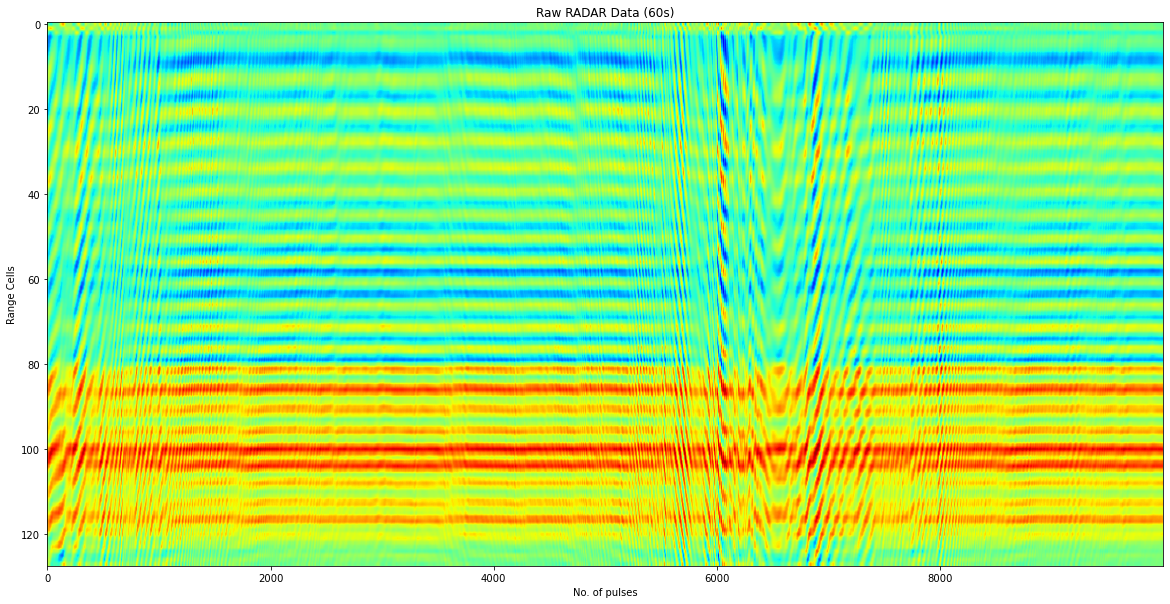

In [270]:
## Visualising radar data currently (no FFT applied)
# %matplotlib inline
# %matplotlib widget # https://matplotlib.org/stable/users/explain/interactive.html

# Flip upside down to get range cell axis to be correct
plt.figure(figsize=[20, 10])
plt.imshow(np.flipud(abs(data_time)), cmap='jet', aspect="auto")
plt.title("Raw RADAR Data (60s)")
plt.xlabel("No. of pulses")
plt.ylabel("Range Cells")
plt.show()

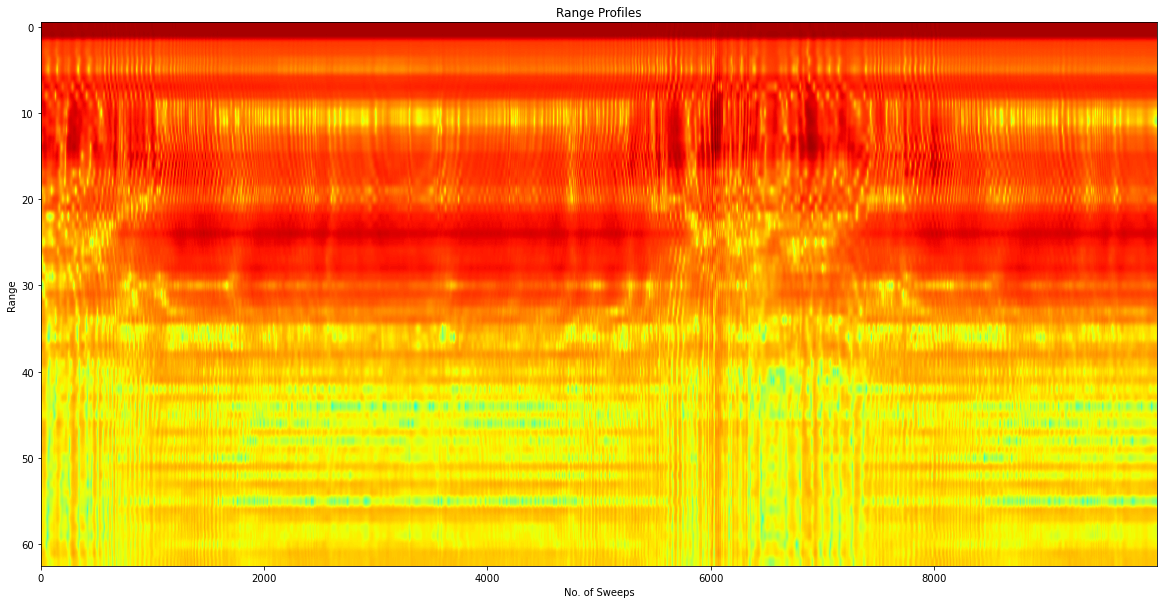

In [271]:
## First FFT transformation
# Apply a FFT along each chirp to compute the range profiles.
win = np.ones((int(number_of_time_samples), data_time.shape[1]))
win = np.ones(data_time.shape)

# Apply fast fourier transform which should compute distance (range) from objects
fft_applied = np.fft.fftshift(np.fft.fft((data_time * win), axis=0), 0)

# Take half as the other half looks to contain only noise
data_range = fft_applied[1:int(number_of_time_samples/2), :] 

plt.figure(figsize=[20, 10])
plt.imshow(20*np.log10(np.flipud(abs(data_range))), cmap='jet', aspect="auto")
plt.title("Range Profiles")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range")
plt.show()

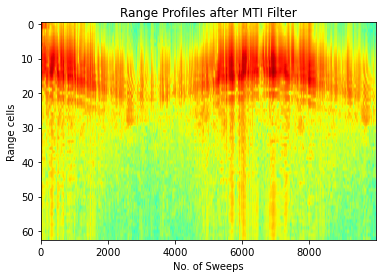

In [272]:
## Apply a MTI filter to the range profiles.
from matplotlib import mlab
from matplotlib import colors
from scipy.signal import butter, lfilter

# IIR Notch filter
x = data_range.shape[1]

# Set 'ns' to nearest even number to x
if x % 2 == 0:
    ns = x
else:
    ns = x - 1
    
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)

(b, a) = butter(4, 0.01, btype="high")

# Apply Filter
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)
    
plt.imshow(20*(np.log10(np.flipud(abs(data_range_MTI)))), cmap='jet', aspect="auto")
plt.title("Range Profiles after MTI Filter")
plt.xlabel("No. of Sweeps")
plt.ylabel("Range cells")
plt.show()

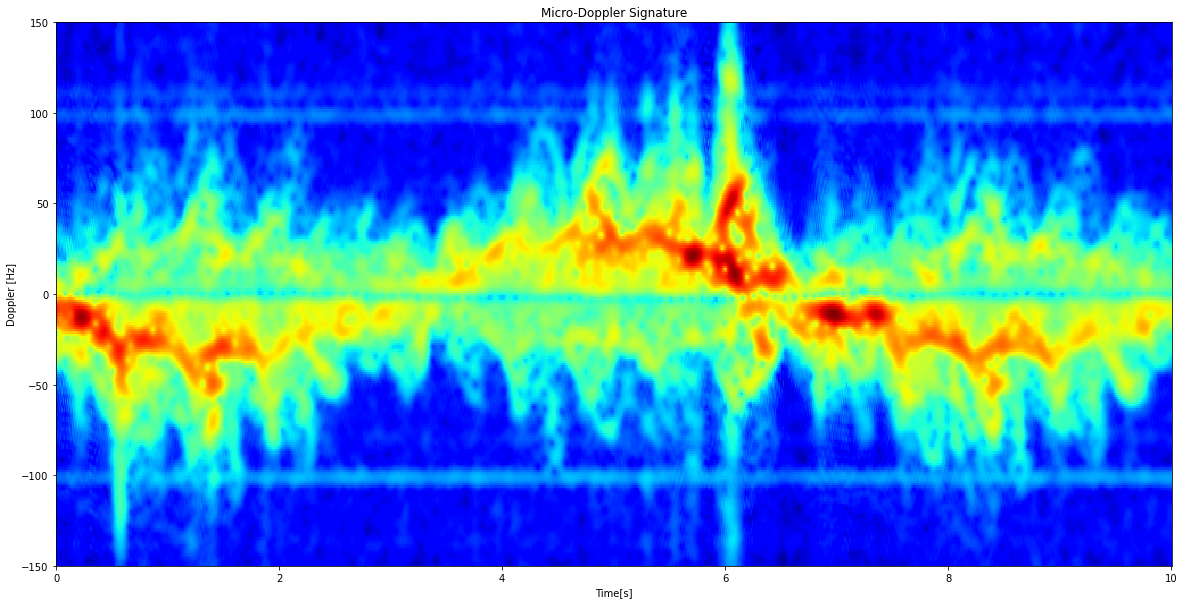

In [273]:
## Computing the micro-Doppler signature from the MTI filtered range profile data.
# Spectrogram processing for 2nd FFT to get Doppler

# Selects range bins
bin_indl = 5
bin_indu = 25

time_window_length = 200
overlap_factor = 0.95
overlap_length = np.round(time_window_length * overlap_factor)
pad_factor = 4
fft_points = pad_factor * time_window_length

prf = 1/sweep_time
doppler_bin = prf / fft_points
doppler_axis = np.arange(-prf / 2, prf / 2 - doppler_bin + 1, doppler_bin)
whole_duration = data_range_MTI.shape[1] / prf
num_segments = np.floor((data_range_MTI.shape[1] - time_window_length) /
    (np.floor(time_window_length * (1 - overlap_factor))))

data_spec_MTI=0
for rbin in range(bin_indl-1, bin_indu):
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(time_window_length),
                            noverlap=overlap_length,
                            NFFT=time_window_length, 
                            mode='complex',
                            pad_to=fft_points )

    data_spec_MTI = data_spec_MTI+abs(s)

time_axis = np.linspace(0, whole_duration, data_spec_MTI.shape[1])

data_spec_MTI.shape

RESULTS_PATH = "Spectrogram Outputs/"

plt.figure(figsize=[20, 10])
plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.flipud(np.abs(data_spec_MTI))), cmap='jet', rasterized=True)
plt.ylim([-150, 150])
plt.title("Micro-Doppler Signature")
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")
plt.savefig(RESULTS_PATH + file_name + ".png", format='png')
plt.show()

Note: Did not apply STFT transformation after second FFT because of MTI filter applied (not sure if STFT is then appropriate). Here is a [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) if want to attempt using STFT.

Can always email Researcher (Floccari) if want guidance. Note that we are moving to using a new radar device, so data wrangling requirements will likely change. 